In [1]:
# Cell 1: imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

print("Imports done.")


2025-11-23 11:29:13.366968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763897353.559218      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763897353.613586      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Imports done.


In [2]:
# Cell 2: load data and prepare
TRAIN_PATH = "/kaggle/input/processed-financial-risk/train_processed.csv"
TEST_PATH  = "/kaggle/input/processed-financial-risk/test_processed.csv"
SAMPLE_PATH = "/kaggle/input/financial-risk-profiling/sample_submission_updated.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample = pd.read_csv(SAMPLE_PATH)

IDCOL = "ProfileID"
TARGET = "RiskFlag"

print("Train shape:", train.shape)
print("Test shape: ", test.shape)

# keep copies of IDs for submission
test_ids = test[IDCOL].copy()

# drop ID cols & separate target
X_full = train.drop(columns=[IDCOL, TARGET]).copy()
y_full = train[TARGET].astype(int).copy()
X_test_full = test.drop(columns=[IDCOL]).copy()

print("Feature matrix shapes:", X_full.shape, X_test_full.shape)


Train shape: (204277, 27)
Test shape:  (51070, 26)
Feature matrix shapes: (204277, 25) (51070, 25)


In [3]:
# Cell 3: clustering features (safe)
print("Adding clustering features...")

# copy
X = X_full.copy()
X_test = X_test_full.copy()

# MiniBatchKMeans labels (cheap)
K = 12
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=4096, random_state=42)
kmeans.fit(X)
X["kmeans_label"] = kmeans.labels_
X_test["kmeans_label"] = kmeans.predict(X_test)

# GaussianMixture with diag covariance (faster & more stable)
G = 6
gmm = GaussianMixture(n_components=G, covariance_type="diag", random_state=42)
gmm.fit(X)
gmm_train_proba = gmm.predict_proba(X)
gmm_test_proba  = gmm.predict_proba(X_test)

for i in range(G):
    X[f"gmm_prob_{i}"] = gmm_train_proba[:, i]
    X_test[f"gmm_prob_{i}"] = gmm_test_proba[:, i]

print("Added clustering features. New shapes:", X.shape, X_test.shape)


Adding clustering features...
Added clustering features. New shapes: (204277, 32) (51070, 32)


In [4]:
# Cell 4: prepare 20% dataset for NN and scale
RND = 42
frac = 0.20

nn_sample = train.sample(frac=frac, random_state=RND).reset_index(drop=True)
print("NN sample shape (20%):", nn_sample.shape)

# prepare features & target for NN sample (must match columns in X created above)
# we used X_full columns + clustering. To ensure columns match, we build X_nn from X by selecting rows by ProfileID
nn_ids = nn_sample[IDCOL].tolist()
X_nn = X.loc[train[IDCOL].isin(nn_ids)].reset_index(drop=True)  # rows in the clustered X
y_nn = train.loc[train[IDCOL].isin(nn_ids), TARGET].reset_index(drop=True)

# Now split nn data into train/val (for NN)
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=RND, stratify=y_nn
)

# scaler for NN only
scaler_nn = StandardScaler()
X_nn_train_s = scaler_nn.fit_transform(X_nn_train)
X_nn_val_s   = scaler_nn.transform(X_nn_val)
X_test_s_nn  = scaler_nn.transform(X_test)   # NN uses same feature set / clustering

print("NN shapes:", X_nn_train_s.shape, X_nn_val_s.shape, "Test scaled:", X_test_s_nn.shape)


NN sample shape (20%): (40855, 27)
NN shapes: (32684, 32) (8171, 32) Test scaled: (51070, 32)


2025-11-23 11:29:43.358429: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
32/32 - 4s - 123ms/step - auc: 0.5997 - loss: 0.7113 - val_auc: 0.6370 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 2/50
32/32 - 1s - 21ms/step - auc: 0.6406 - loss: 0.5742 - val_auc: 0.6940 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 3/50
32/32 - 1s - 20ms/step - auc: 0.6633 - loss: 0.4853 - val_auc: 0.7121 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 4/50
32/32 - 1s - 20ms/step - auc: 0.6812 - loss: 0.4157 - val_auc: 0.7148 - val_loss: 0.3636 - learning_rate: 0.0010
Epoch 5/50
32/32 - 1s - 20ms/step - auc: 0.6872 - loss: 0.3715 - val_auc: 0.7132 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 6/50
32/32 - 1s - 20ms/step - auc: 0.6999 - loss: 0.3502 - val_auc: 0.7230 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 7/50
32/32 - 1s - 20ms/step - auc: 0.7120 - loss: 0.3388 - val_auc: 0.7303 - val_loss: 0.3285 - learning_rate: 0.0010
Epoch 8/50
32/32 - 1s - 20ms/step - auc: 0.7363 - loss: 0.3281 - val_auc: 0.7279 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 9

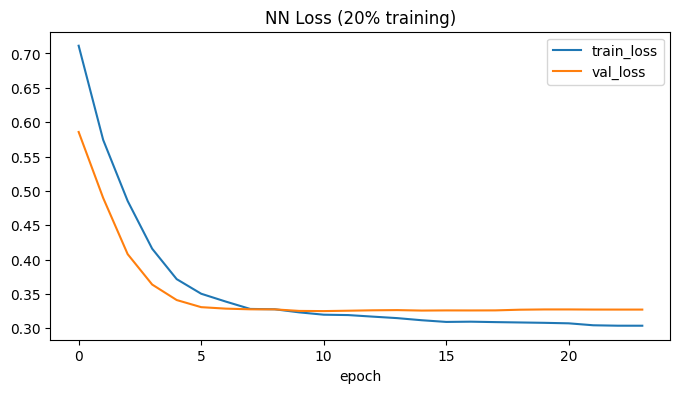

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
NN validation AUC (on sampled holdout): 0.7388089860103092
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [5]:
# Cell 5: build and train NN on 20% data
def build_nn(input_dim, lr=1e-3, l2=1e-5, dropout=0.3):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout*0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout*0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="auc")])
    return model

nn_model = build_nn(X_nn_train_s.shape[1])
nn_model.summary()

# callbacks
early = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, verbose=1)

history = nn_model.fit(
    X_nn_train_s, y_nn_train,
    validation_data=(X_nn_val_s, y_nn_val),
    epochs=50,
    batch_size=1024,
    callbacks=[early, reduce_lr],
    verbose=2
)

# save loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("NN Loss (20% training)"); plt.xlabel("epoch")
plt.savefig("nn_20pct_loss.png", dpi=200)
plt.show()

# NN validation AUC
nn_val_probs = nn_model.predict(X_nn_val_s, batch_size=2048).ravel()
nn_val_auc = roc_auc_score(y_nn_val, nn_val_probs)
print("NN validation AUC (on sampled holdout):", nn_val_auc)

# NN test probabilities (to be blended later)
nn_test_probs = nn_model.predict(X_test_s_nn, batch_size=2048).ravel()


In [6]:
# Cell 6 (FIXED): OOF for boosters (Kaggle compatible)
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RND)

oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))

test_lgb = np.zeros(len(X_test))
test_xgb = np.zeros(len(X_test))
test_cat = np.zeros(len(X_test))

from xgboost import callback as xgb_callback


lgb_params = dict(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

xgb_params = dict(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
)

cat_params = dict(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)


for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y_full), 1):
    print(f"\n--- FOLD {fold} ---")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y_full.iloc[tr_idx], y_full.iloc[val_idx]

    # -------------------------
    # LightGBM (Kaggle-compatible)
    # -------------------------
    lgbm = lgb.LGBMClassifier(**lgb_params)
    lgbm.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(50, verbose=False)
        ]
    )
    oof_lgb[val_idx] = lgbm.predict_proba(X_val)[:, 1]
    test_lgb += lgbm.predict_proba(X_test)[:, 1] / NFOLDS
    print("LGB fold AUC:", roc_auc_score(y_val, oof_lgb[val_idx]))

    # -------------------------
    # XGBoost (Kaggle-compatible)
    # -------------------------
    xgbm = XGBClassifier(**xgb_params)
    xgbm.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[
            xgb_callback.EarlyStopping(rounds=50, save_best=True, maximize=True)
        ]
    )
    oof_xgb[val_idx] = xgbm.predict_proba(X_val)[:, 1]
    test_xgb += xgbm.predict_proba(X_test)[:, 1] / NFOLDS
    print("XGB fold AUC:", roc_auc_score(y_val, oof_xgb[val_idx]))

    # -------------------------
    # CatBoost
    # -------------------------
    cat = CatBoostClassifier(**cat_params)
    cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
    oof_cat[val_idx] = cat.predict_proba(X_val)[:, 1]
    test_cat += cat.predict_proba(X_test)[:, 1] / NFOLDS
    print("CAT fold AUC:", roc_auc_score(y_val, oof_cat[val_idx]))



--- FOLD 1 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18970, number of negative: 144451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 163421, number of used features: 32
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116081 -> initscore=-2.030082
[LightGBM] [Info] Start training from score -2.030082
LGB fold AUC: 0.7472727135839764
[0]	validation_0-auc:0.69790
[1]	validation_0-auc:0.70220
[2]	validation_0-auc:0.71922
[3]	validation_0-auc:0.72150
[4]	validation_0-auc:0.72426
[5]	validation_0-auc:0.72635
[6]	validation_0-auc:0.72718
[7]	validation_0-auc:0.72725

In [7]:
# Cell 7: OOF AUCs
print("OOF LGB AUC:", roc_auc_score(y_full, oof_lgb))
print("OOF XGB AUC:", roc_auc_score(y_full, oof_xgb))
print("OOF CAT AUC:", roc_auc_score(y_full, oof_cat))
print("NN validation AUC (20% holdout):", nn_val_auc)


OOF LGB AUC: 0.7513913338812572
OOF XGB AUC: 0.752254797872534
OOF CAT AUC: 0.7542116318922092
NN validation AUC (20% holdout): 0.7388089860103092


In [8]:
# Cell 8: compute weights from AUCs (add tiny eps)
eps = 1e-6
auc_lgb = roc_auc_score(y_full, oof_lgb) + eps
auc_xgb = roc_auc_score(y_full, oof_xgb) + eps
auc_cat = roc_auc_score(y_full, oof_cat) + eps
auc_nn  = nn_val_auc + eps

print("AUCs:", auc_lgb, auc_xgb, auc_cat, auc_nn)

# Decide weights: boosters rely on OOF, NN relies on its small-holdout AUC.
raw = np.array([auc_lgb, auc_xgb, auc_cat, auc_nn])
weights = raw / raw.sum()
print("Blending weights (LGB, XGB, CAT, NN):", weights)

# blended test probabilities
test_blend = weights[0]*test_lgb + weights[1]*test_xgb + weights[2]*test_cat + weights[3]*nn_test_probs


AUCs: 0.7513923338812573 0.752255797872534 0.7542126318922092 0.7388099860103092
Blending weights (LGB, XGB, CAT, NN): [0.25074237 0.25103051 0.25168352 0.2465436 ]


In [9]:
# Cell 9: threshold and submission
final_probs = test_blend
final_preds = (final_probs >= 0.5).astype(int)

# Create submission with required ProfileID column and RiskFlag as 0/1
submission = pd.DataFrame({
    "ProfileID": test[IDCOL],
    "RiskFlag": final_preds
})

OUT_PATH = "blend_lgb_xgb_cat_nn_20pct_clust.csv"
submission.to_csv(OUT_PATH, index=False)
print("Saved submission to", OUT_PATH)

# Quick diagnostics: print distribution
print("Final predicted positives:", final_preds.sum(), "out of", len(final_preds))


Saved submission to blend_lgb_xgb_cat_nn_20pct_clust.csv
Final predicted positives: 535 out of 51070
